# Dataset Description 

The dataset taken from the UCI Machine Learning repository contains medical measurements for patients who suffer from some form of heart disease (`target` = 1, 2, 3, 4), or who have not been diagnosed with heart disease (`target` = 0).

The data is collected from a total of 4 locations:
     1. Cleveland Clinic Foundation (cleveland.csv)
     2. Hungarian Institute of Cardiology, Budapest (hungary.csv)
     3. V.A. Medical Center, Long Beach, CA (va.csv)
     4. University Hospital, Zurich, Switzerland (switzerland.csv)

A summary of the attributes:

| Description         | Variable        | Values             | Type    | 
|:-------------------:|:---------------:|:------------------:| :-----: | 
| age                 | age in years    | n/a                | numeric (`float64`) |
| sex                 | patient gender  | 1: male, 0: female | categorical |
| chest_pain          | chest pain type | 1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic | categorical |
| rest_blood_pressure | resting blood pressure in mm Hg | n/a | numeric (`float64`) |
| cholestorol         | serum cholestoral in mg/dl      | n/a | numeric (`float64`) |
| fast_blood_sugar    | fasting blood sugar > 120 mg/dl | 1: true, 0: false | categorical |
| rest_ecg            | ecg signal at rest | 0: normal, 1: having ST-T wave abnormality, 2: left ventricular hypertrophy | categorical |
| max_heart_rate      | maximum heart rate achieved     | n/a | numeric (`float64`) |
| exercise_angina     | exercise induced angina         | 1: yes, 0: no | categorical |
| st_depression       | ST depression induced by exercise relative to rest | n/a | numeric (`float64`) |
| st_slope            | the slope of the peak exercise ST segment | 1: upsloping, 2: flat, 3: downsloping | categorical |
| major_vessels       | number of major vessels | 0-3: colored by flourosopy | numeric (`float64`) |
| thal                | n/a | 3: normal, 6: fixed defect, 7: reversable defect | categorical |
| target              | diagnosis of heart disease | 0: false, 1: true | categorical |

# Preprocessing the data

In general, real world datasets tend to be:
- **Incomplete**: lacking attribute values, lacking certain attributes of interest, or containing only aggregate data
- **Noisy**: containing errors or outliers
- **Inconsistent**: containing discrepancies in codes or names
   
These inconsistencies must be handled carefully to achieve the most accuracy and reliability possible when training the final model. The data importing, wrangling and consolidation phase will be carried out below, and will aim to:
- Import the 4 datasets and resolve any inconsistencies between them
- Fill in missing values with a "best guess" approach using the `mean` and `mode` (described in detail later)
- Establish data types
- Identify and remove outliers

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 6)})

from IPython.display import Markdown

## Reading in the data
The data is read in from 4 separate files:
- cleveland.csv
- hungary.csv
- switzerland.csv
- va.csv

Missing values are marked as either `?` or `-9`.

In [3]:
names=['age', 'sex', 'chest_pain', 'rest_blood_pressure', 'cholestorol', 'fast_blood_sugar', 'rest_ecg', 'max_heart_rate', 'exercise_angina', 'st_depression', 'st_slope', 'major_vessels', 'thal', 'target']
files = ['cleveland.csv', 'hungary.csv', 'switzerland.csv', 'va.csv']

# Read in the files as a single dataframe
dfs = (pd.read_csv('./data/' + f, names=names, na_values=['?', -9]) for f in files)
df = pd.concat(dfs, ignore_index=True)

In [4]:
message = ("Data set consists of %d cases (rows) with %s attributes (cols) and a single target."
% (df.shape[0], df.shape[1]-1))
Markdown(message)

Data set consists of 921 cases (rows) with 13 attributes (cols) and a single target.

In [5]:
df.head(5)

,age,sex,chest_pain,rest_blood_pressure,cholestorol,fast_blood_sugar,rest_ecg,max_heart_rate,exercise_angina,st_depression,st_slope,major_vessels,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0


### Correcting data types
The categorical variables are read in as `int64`s, so these should be changed to type `category`:

In [6]:
# Convert categorical variables
df[['sex', 'chest_pain', 'fast_blood_sugar', 'rest_ecg', 'exercise_angina', 'st_slope', 'major_vessels', 'thal', 'target']] = df[['sex', 'chest_pain', 'fast_blood_sugar', 'rest_ecg', 'exercise_angina', 'st_slope', 'major_vessels', 'thal', 'target']].astype('category')

In [7]:
df.dtypes

age                     float64
sex                    category
chest_pain             category
rest_blood_pressure     float64
cholestorol             float64
fast_blood_sugar       category
rest_ecg               category
max_heart_rate          float64
exercise_angina        category
st_depression           float64
st_slope               category
major_vessels          category
thal                   category
target                 category
dtype: object

## Data imputation

Imputation methods involve replacing missing values with estimated ones based on information available
in the data set [[1](http://www.aaai.org/Papers/KDD/1996/KDD96-023.pdf)]. There are multiple different options for filling in missing data, from naive methods such as the mean, to more robust prediction models like K-Nearest Neighbours.

Mean and mode imputation are some of the most frequently used methods for replacing missing data in Machine Learning problems. These methods are based on filling in an unknown value by using the average of the known values for that attribute (quantitative), or simply filling it in using the most frequently occurring value of that attribute (qualitative).

In [8]:
print("Shape of the dataset:", df.shape)
df.isnull().sum()

Shape of the dataset: (921, 14)


age                      1
sex                      1
chest_pain               1
rest_blood_pressure     60
cholestorol             31
fast_blood_sugar        91
rest_ecg                 3
max_heart_rate          56
exercise_angina         56
st_depression           63
st_slope               310
major_vessels          611
thal                   487
target                   1
dtype: int64

### Observations
- Age and sex have very few missing records. These will be replaced with the mean of the dataset and the mode (the most frequent) respectively
- One record does not contain a `target` outcome (healthy or not healthy), so this can be removed
- `major_vessels` has the most amount of missing values, next to `thal`. These missing values are about a 2/3 of the length of the dataset, so the column could probably be dropped. For now however the values will be imputed.
- For other variables, it makes sense to fill the missing values with means and modes from a subset of similar patients. For example, an older patient is more likely to have a similar heart rate to another patient of similar age and gender, so it might not make sense to replace this value with the average of all of the patient's heart rates. 

Replacing the age and sex will be done using sklearn's `Imputer`:

In [9]:
from sklearn.preprocessing.imputation import Imputer 

mean_imputer = Imputer(missing_values='NaN', strategy='mean')
mode_imputer = Imputer(missing_values='NaN', strategy='most_frequent')

# Replace missing values in age with the mean
df['age'] = mean_imputer.fit_transform(df[['age']]) 

# Replace missing values in sex with the mode
df['sex'] = mode_imputer.fit_transform(df[['sex']]) 

For the other columns, replacing will be done by using the mean or mode of a subset of the data. 
Specific functions are defined for this purpose:

In [10]:
def impute_mean(attr):
    """
    Fill NaNs for numerical attributes with 
    the attribute mean of a subset of patients
    with similar age and sex. 
    """
    indices = df[df.loc[:, attr].isnull() == True].index

    for i in indices:
        # get age and sex for corresponding record
        age = df['age'].iloc[i]
        sex = df['sex'].iloc[i]

        # get a subset of patients within a similar range and sex
        subset = df[df['age'].between(age - 5, age + 5) & df['sex'] == sex]
        mean = subset[attr].mean() 
        
        # fill the record using the mean of attribute from the subset
        df[attr].fillna(mean, inplace=True)
        #df[attr] = mean_imputer.fit_transform(df[[attr]]) 
        
def impute_mode(attr):
    """
    Fill NaNs for categorical attributes with 
    the attribute mode of a subset of patients
    with similar age and sex. 
    """
    indices = df[df.loc[:, attr].isnull() == True].index

    for i in indices:
        # get age and sex for corresponding record
        age = df['age'].iloc[i]
        sex = df['sex'].iloc[i]

        # get a subset of patients within a similar range and sex
        subset = df[df['age'].between(age - 5, age + 5) & df['sex'] == sex]
        mode = subset[attr].mode()[0]
        
        # fill the record using the mean of attribute from the subset
        df[attr].fillna(mode, inplace=True)

In [11]:
# Fill missing values in numerical columns
nums = ['rest_blood_pressure', 'cholestorol', 'max_heart_rate', 'st_depression']
for i in nums:
    impute_mean(i)
    print("NaNs for", i, df[i].isnull().sum())
    
# Fill missing values in categorical columns
cats = ['chest_pain', 'fast_blood_sugar', 'rest_ecg', 'exercise_angina', 'st_slope', 'major_vessels', 'thal']
for i in cats:
    impute_mode(i)
    print("NaNs for", i, df[i].isnull().sum())
    
# Drop the record with a missing target
df.dropna(inplace=True)

NaNs for rest_blood_pressure 0
NaNs for cholestorol 0
NaNs for max_heart_rate 0
NaNs for st_depression 0
NaNs for chest_pain 0
NaNs for fast_blood_sugar 0
NaNs for rest_ecg 0
NaNs for exercise_angina 0
NaNs for st_slope 0
NaNs for major_vessels 0
NaNs for thal 0


All of the missing values have now been replaced:

In [12]:
df.isnull().sum()

age                    0
sex                    0
chest_pain             0
rest_blood_pressure    0
cholestorol            0
fast_blood_sugar       0
rest_ecg               0
max_heart_rate         0
exercise_angina        0
st_depression          0
st_slope               0
major_vessels          0
thal                   0
target                 0
dtype: int64

In [13]:
# Convert categorical variables
df[['sex', 'chest_pain', 'fast_blood_sugar', 'rest_ecg', 'exercise_angina', 'st_slope', 'major_vessels', 'thal', 'target']] = df[['sex', 'chest_pain', 'fast_blood_sugar', 'rest_ecg', 'exercise_angina', 'st_slope', 'major_vessels', 'thal', 'target']].astype('category')

## Categorical variables

In [14]:
print("Categories\n")
for i in (cats + ['target']):
    print(i, "\n", df[i].cat.categories.tolist())

Categories

chest_pain 
 [1.0, 2.0, 3.0, 4.0]
fast_blood_sugar 
 [0.0, 1.0]
rest_ecg 
 [0.0, 1.0, 2.0]
exercise_angina 
 [0.0, 1.0]
st_slope 
 [1.0, 2.0, 3.0]
major_vessels 
 [0.0, 1.0, 2.0, 3.0, 9.0]
thal 
 [3.0, 6.0, 7.0]
target 
 [0.0, 1.0, 2.0, 3.0, 4.0]


### Observations
- `target` is the outcome variable which dictates whether or not a patient is healthy (0), or have some form of cardiovascular disease (4 types in total: 1, 2, 3, 4). For the purpose of predicting whether or not a patient is at risk, only two should suffice (0 = healthy, 1 = at risk).
- Some categories contain `-9`, which is the equivalent to a missing value. These were converted to NaNs when the data was read in

In [15]:
# Replace the categories 1, 2, 3, 4 with just 1
df['target'] = df['target'].replace({0.0: 0, 1.0: 1, 2.0: 1, 3.0: 1, 4.0: 1}).astype('category')
df['target'].unique()

[0, 1]
Categories (2, int64): [0, 1]

# Exploratory data analysis 

## target
* Target binary variable
* Indicates whether a patient was diagnosed with heart disease or not

In [19]:
df1 = df.target.value_counts()
df1

1    509
0    411
Name: target, dtype: int64

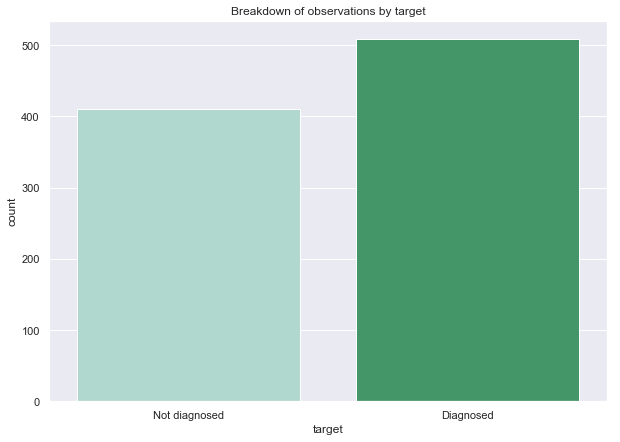

In [20]:
ax = sns.countplot(x="target", data=df, palette="BuGn")
ax.set_title("Breakdown of observations by target")
ax.set_xticklabels(["Not diagnosed", "Diagnosed"])
plt.show()

In [21]:
display_fraction = lambda n,d: (n/d*100, n, d)

message = ("Dataset is almost balanced with %.1f%%  (%d/%d) of the cases negative and %.1f%% positive (%d/%d).\n" %
(*display_fraction(df1[0], df1.sum()), *display_fraction(df1[1], df1.sum())))

display(Markdown(message))

Dataset is almost balanced with 44.7%  (411/920) of the cases negative and 55.3% positive (509/920).


## Other attributes

In [22]:
df.agg("nunique")

age                     50
sex                      2
chest_pain               4
rest_blood_pressure     62
cholestorol            218
fast_blood_sugar         2
rest_ecg                 3
max_heart_rate         120
exercise_angina          2
st_depression           54
st_slope                 3
major_vessels            5
thal                     3
target                   2
dtype: int64

## age
* Age of the patient in years
* Integer

In [34]:
df.age.describe()

count    920.000000
mean      53.510870
std        9.424685
min       28.000000
25%       47.000000
50%       54.000000
75%       60.000000
max       77.000000
Name: age, dtype: float64

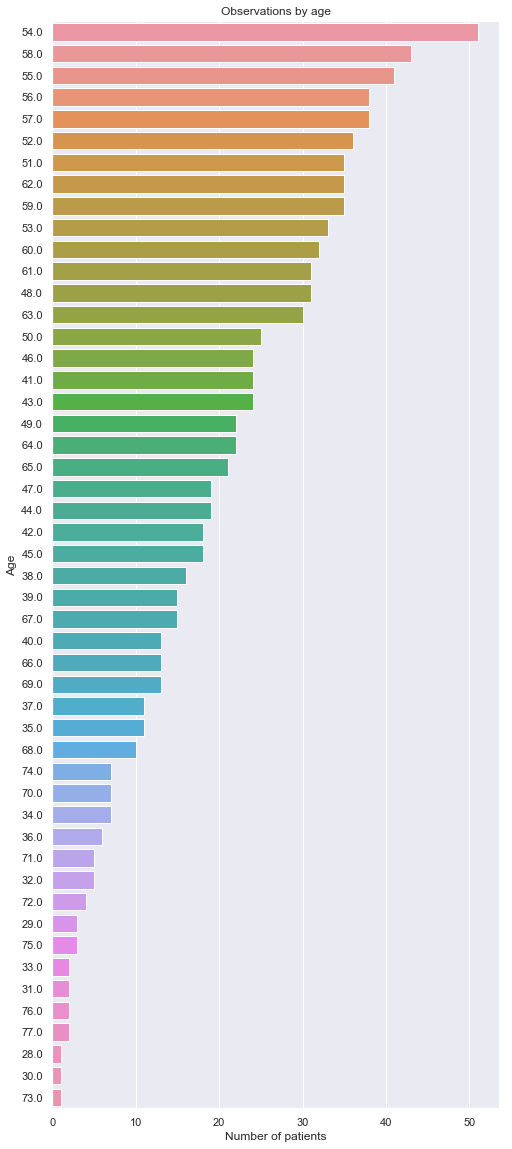

In [47]:
fig = plt.figure(figsize=(8, 20))
s1 = df.age.value_counts()

ax = sns.countplot(y="age", data=df, order=s1.index)
ax.set_xlabel("Number of patients")
ax.set_ylabel("Age")
ax.set_title("Observations by age")

plt.show()

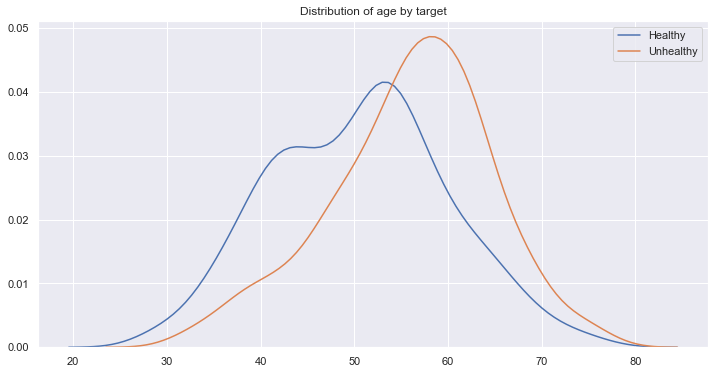

In [39]:
ax = sns.kdeplot(df[df.target == 0].age, label="Healthy")
ax = sns.kdeplot(df[df.target == 1].age, label="Unhealthy")
ax.set_title("Distribution of age by target")
plt.show()

In [50]:
message = ("The median age is %d for sick patients and %d for healthy patients.\n" %
(df[df.target == 1].age.median(), df[df.target == 0].age.median()))

display(Markdown(message))

The median age is 57 for sick patients and 51 for healthy patients.


* The age distribution of healthy patients is bimodal, with peaks around 43 years and 53 years 
* The age distribution of unhealthy patients is unimodal and slightly skewed to the left

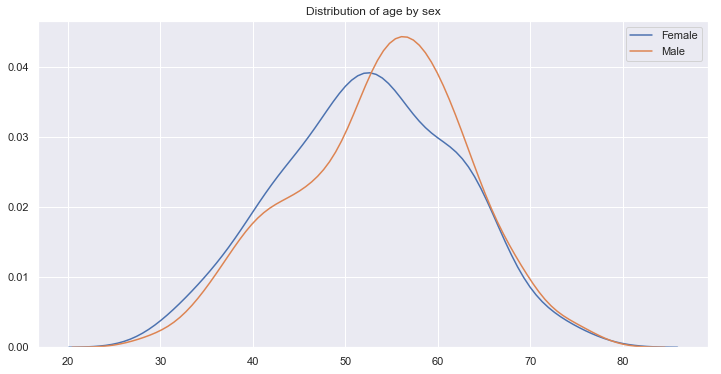

In [52]:
ax = sns.kdeplot(df[df.sex == 0].age, label="Female")
ax = sns.kdeplot(df[df.sex == 1].age, label="Male")
ax.set_title("Distribution of age by sex")
plt.show()

In [51]:
message = ("The median age is %d for female patients and %d for male patients.\n" %
(df[df.sex == 0].age.median(), df[df.sex == 1].age.median()))

display(Markdown(message))

The median age is 53 for female patients and 55 for male patients.


## sex
* Binary variable
* 0 = Female, 1 = Male

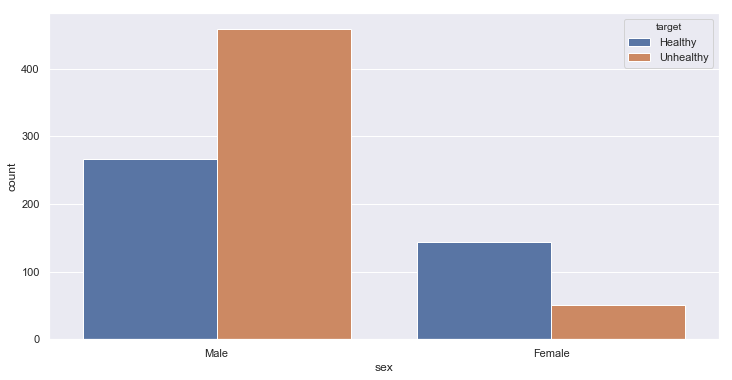

In [60]:
data = df.copy()
data['sex'] = data['sex'].replace({0: 'Female', 1: 'Male'})
data['target'] = data['target'].replace({0: 'Healthy', 1: 'Unhealthy'})
ax = sns.countplot(x="sex", hue="target", data=data)

In [27]:
df.sex.value_counts()

1.0    726
0.0    194
Name: sex, dtype: int64

In [64]:
ct = pd.crosstab(df.sex, df.target, margins=True)
ct

target,0,1,All
sex,,,
0.0,144,50,194
1.0,267,459,726
All,411,509,920


In [93]:
message = ("%.1f percent of male patients are healthy, %.1f percent are unhealthy. \n" %
(ct.loc[1, 0]/(ct.loc[1, 0] + ct.loc[1, 1])*100, ct.loc[1, 1]/(ct.loc[1, 0] + ct.loc[1, 1])*100))

display(Markdown(message))

36.8 percent of male patients are healthy, 63.2 percent are unhealthy. 


In [94]:
message = ("%.1f percent of female patients are healthy, %.1f percent are unhealthy. \n" %
(ct.loc[0, 0]/(ct.loc[0, 0] + ct.loc[0, 1])*100, ct.loc[0, 1]/(ct.loc[0, 0] + ct.loc[0, 1])*100))

display(Markdown(message))

74.2 percent of female patients are healthy, 25.8 percent are unhealthy. 


In [42]:
df.groupby(['sex']).target.value_counts()

sex  target
0.0  0         144
     1          50
1.0  1         459
     0         267
Name: target, dtype: int64

In [28]:
display_fraction = lambda n,d: (n/d*100, n, d)

message = ("Dataset is not balanced with %.1f%%  (%d/%d) of the cases negative and %.1f%% positive (%d/%d).\n" %
(*display_fraction(df1[0], df1.sum()), *display_fraction(df1[1], df1.sum())))

display(Markdown(message))

Dataset is not balanced with 44.7%  (411/920) of the cases negative and 55.3% positive (509/920).


## chest_pain
* Chest pain type	
* Categorical variable
* 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic	

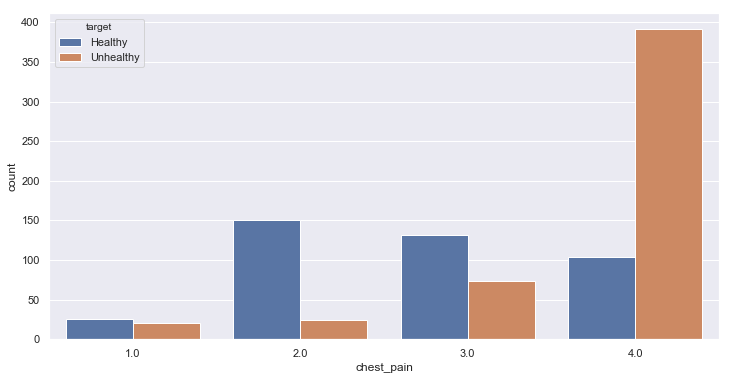

In [95]:
ax = sns.countplot(x="chest_pain", hue="target", data=data)
plt.show()

* The majority of patients diagnosed with cardiovascular disease did not display symptoms of chest pain
* Most healthy patients showed sympots of chest pain (presumably why they were admitted)

## rest_blood_pressure
* Resting blood pressure in mm Hg
* Continuous variable

In [96]:
df.rest_blood_pressure.describe()

count    920.000000
mean     132.178155
std       18.444724
min        0.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: rest_blood_pressure, dtype: float64

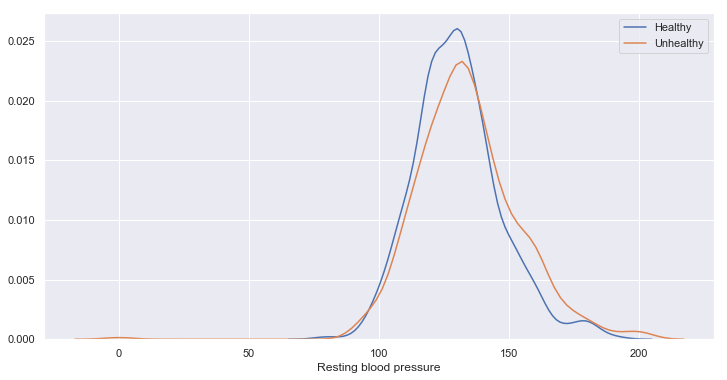

In [119]:
ax = sns.kdeplot(df[df.target == 0].rest_blood_pressure, label="Healthy")
ax = sns.kdeplot(df[df.target == 1].rest_blood_pressure, label="Unhealthy")
ax.set_xlabel("Resting blood pressure")
plt.show()

In [120]:
message = ("The median blood pressure is %d for healthy patients and %d for unhealthy patients.\n" %
(df[df.target == 0].rest_blood_pressure.median(), df[df.target == 1].rest_blood_pressure.median()))

display(Markdown(message))

The median blood pressure is 130 for healthy patients and 132 for unhealthy patients.


## cholestorol 
* Cholestoral in mg/dl	
* Continuous variable

In [97]:
df.cholestorol.describe()

count    920.000000
mean     198.702917
std      108.982529
min        0.000000
25%      177.750000
50%      221.000000
75%      267.000000
max      603.000000
Name: cholestorol, dtype: float64

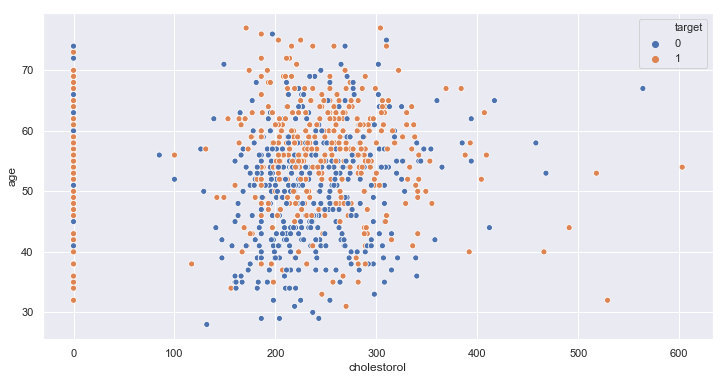

In [124]:
sns.scatterplot(x="cholestorol", y="age", hue="target", data=df)
plt.show()

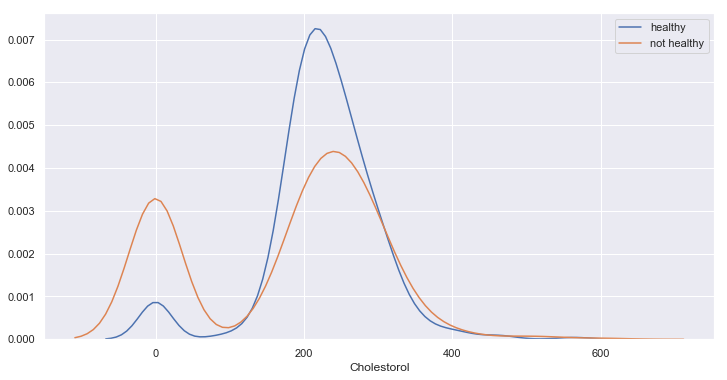

In [126]:
ax = sns.kdeplot(df.cholestorol[df.target == 0], label='healthy')
ax = sns.kdeplot(df.cholestorol[df.target == 1], label='not healthy')
ax.set_xlabel("Cholestorol")
plt.show()

* Plotting the cholestorol shows an unusual straight line - about 100-200 missing values for cholestorol are entered as 0 instead of NaN, so these values were not imputed

## fast_blood_sugar

In [98]:
df.fast_blood_sugar.describe()

count     920.0
unique      2.0
top         0.0
freq      782.0
Name: fast_blood_sugar, dtype: float64

## rest_ecg

In [99]:
df.rest_ecg.describe()

count     920.0
unique      3.0
top         0.0
freq      553.0
Name: rest_ecg, dtype: float64

## max_heart_rate  

In [100]:
df.max_heart_rate.describe()

count    920.000000
mean     137.510776
std       25.138876
min       60.000000
25%      120.000000
50%      138.000000
75%      156.000000
max      202.000000
Name: max_heart_rate, dtype: float64

## exercise_angina

In [101]:
df.exercise_angina.describe()

count     920.0
unique      2.0
top         0.0
freq      583.0
Name: exercise_angina, dtype: float64

## st_depression

In [102]:
df.st_depression.describe()

count    920.000000
mean       0.883664
std        1.053930
min       -2.600000
25%        0.000000
50%        0.800000
75%        1.500000
max        6.200000
Name: st_depression, dtype: float64

## st_slope

In [103]:
df.st_slope.describe()

count     920.0
unique      3.0
top         2.0
freq      654.0
Name: st_slope, dtype: float64

## major_vessels

In [104]:
df.major_vessels.describe()

count     920.0
unique      5.0
top         0.0
freq      791.0
Name: major_vessels, dtype: float64

## thal

In [105]:
df.thal.describe()

count     920.0
unique      3.0
top         3.0
freq      682.0
Name: thal, dtype: float64